In [28]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm 
from collections import defaultdict
import sr_processing as sr
import plot_utils as plu
from joblib import Parallel, delayed

In [ ]:
def compute_corr_matrix(item):
    i, v = item
    return i, sr.get_corr_mat(v)

class hu_RFmapping_fr:
    def __init__(self,main_path):
        self.main_path = main_path
        self.df_data = pd.read_pickle(os.path.join(main_path,'data.pkl'))
        self.df_epochs = pd.read_pickle(os.path.join(main_path,'epochs.pkl'))
        self.vis_epochs = [i for i in self.df_epochs['stim_name'] if 'RFMapping' in i]
        self.cell_labels = self.df_data.cell_type.values
        self.region_labels = self.df_data.region.values
        self.layer_labels = self.df_data.layer.values
    def load_data(self):
        self.epoch_paths = [os.path.join(self.main_path,ep) for ep in self.vis_epochs ]
        self.trial_info = {ep: pd.read_csv(os.path.join(ep_path,'trial_info.csv')) for
                         ep,ep_path in zip(self.vis_epochs ,self.epoch_paths)}
        self.trial_dic = {ep: sr.get_index_maps(self.trial_info[ep]) for ep in
                         self.vis_epochs}
        self.trial_data = {ep:sr.load_pickle(os.path.join(ep_path,'firing_rates.pkl'))
                           for ep,ep_path in zip(self.vis_epochs ,self.epoch_paths)}
        return
    def get_vis_epochs_keys(self):
        e_k_length = []
        for epoch in self.vis_epochs:
            k_s1 = list(self.trial_dic[epoch].keys())
            e_k_length.append(len(set(k_s1)))
        if len(set(e_k_length)) == 1:
            self.trial_type_keys = k_s1
            return 
        else:
            print('Trial types do not match across trials')
    def get_cor_matrices(self):
        self.main_dic = {}
        for vis_epoch in self.vis_epochs:
            items = self.trial_data[vis_epoch].items()
            
            # n_jobs=-1 uses all available CPU cores
            results = Parallel(n_jobs=-1)(delayed(compute_corr_matrix)(item) for item in items)
            
            self.main_dic[vis_epoch] = dict(results)
        return 

In [50]:
def subset_and_organize_matrices(regions, layers, matrix, target_region):
    """
    Subset by region and organize by layers, returning matrices.
    
    Args:
        regions: array of region strings
        layers: array of layer strings  
        matrix: (neuron x time_points) matrix
        target_region: string of region to subset
    
    Returns:
        organized_matrix: (neuron x time_points) matrix with all neurons from target region
        layer_labels: array of layer strings corresponding to each neuron row
        layer_info: dict with layer statistics
    """
    # Convert to numpy arrays
    regions = np.array(regions)
    layers = np.array(layers)
    
    # Subset by region
    region_mask = regions == target_region
    subset_layers = layers[region_mask]
    subset_matrix = matrix[region_mask, :]
    
    # Get unique layers and sort them
    unique_layers = sorted(np.unique(subset_layers))
    
    # Reorganize data by layer order
    organized_rows = []
    organized_layer_labels = []
    layer_info = {}
    
    for layer in unique_layers:
        layer_mask = subset_layers == layer
        layer_data = subset_matrix[layer_mask, :]
        
        organized_rows.append(layer_data)
        organized_layer_labels.extend([layer] * np.sum(layer_mask))
        
        # Store layer info
        layer_info[layer] = {
            'start_idx': len(organized_layer_labels) - np.sum(layer_mask),
            'end_idx': len(organized_layer_labels),
            'n_neurons': np.sum(layer_mask)
        }
    
    # Concatenate all layers
    organized_matrix = np.vstack(organized_rows)
    organized_layer_labels = np.array(organized_layer_labels)
    
    return organized_matrix, organized_layer_labels, layer_info

In [51]:
session_path = '/home/tony/Halluci-Nations/scratch/ecephys_714527_2024-05-15_13-00-23_nwb_2025-08-03_21-11-22/'
test_session = hu_RFmapping_fr(session_path)
test_session.load_data()
test_session.get_vis_epochs_keys()

In [30]:
def compute_corr_matrix(item):
    i, v = item
    return i, sr.get_corr_mat(v)

In [57]:
test_session.region_labels.shape
test_session.layer_labels.shape
test_session.region_labels.shape

(556,)

In [7]:
# allen brain atlas
# root unknown
# cingulum bundle (cing); MEDIAL FOREBRAIN BUNDLE SYSTEM
# Primary somatosensory area (SSp)
# Secondary motor area (MOs)
# dorsal hippocampal commissure (dhc)
# LATERAL FOREBRAIN BUNDLE SYSTEM
# posterior forceps (fp)
#np.unique(test_session.region_labels)

100%|██████████| 193/193 [00:22<00:00, 39.12it/s]

In [12]:
np.unique(test_session.region_labels)

array(['MOs', 'RSPd', 'SSp', 'VISp', 'cing', 'dhc', 'fp', 'root'],
      dtype=object)

In [45]:
epochs = ['Pre_Injection','Post_Injectipon_Early','Pre_Injection_late']

In [49]:
matrices[0].shape[0]

350

In [63]:
reg = 'fp'

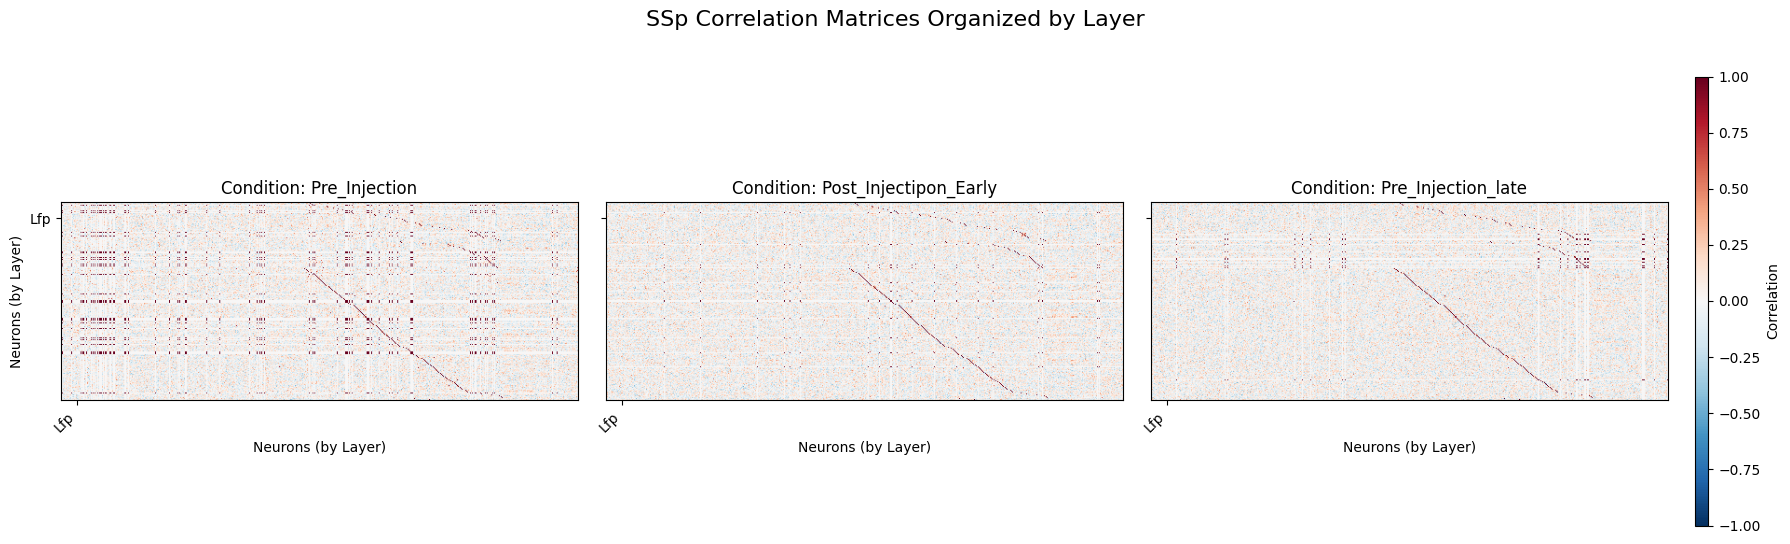

In [76]:
matrices =[main_dic[vis_epoch][(7777,7777,7777)] for vis_epoch in test_session.vis_epochs]
mat_new = []
for i in matrices:
    mat,unique_layers,layer_info = subset_and_organize_matrices(test_session.region_labels, test_session.cell_labels, i, reg)
    mat_new.append(mat)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(mat_new,layer_info,unique_layers,epochs,title = reg)

In [75]:
mat_new[0].shape

(213, 556)

In [71]:
mat_new[0]

(array([[-2.75104264e-01, -1.06752214e-16, -1.02930047e-01, ...,
          1.85311151e-02, -4.00000000e-02, -2.17273676e-01],
        [-9.08307758e-02,  4.75047352e-17,  5.59608109e-02, ...,
          5.62644728e-02,  2.15316114e-01,  9.66063130e-02],
        [ 2.62166118e-01, -5.12410627e-17,  2.26575048e-02, ...,
          1.00592786e-01,  1.70402859e-01, -2.93841711e-02],
        ...,
        [ 8.81940393e-02, -1.49453099e-17,  1.54478282e-01, ...,
         -1.69261217e-01, -9.22448108e-02, -4.78002630e-02],
        [-7.04963623e-02, -1.11022302e-16,  3.46199044e-03, ...,
          3.50492778e-01,  1.41264483e-01, -1.38037542e-02],
        [ 8.77522216e-02, -5.76461955e-17, -1.48566726e-01, ...,
         -2.05063099e-01, -5.77350269e-02, -2.24005384e-02]],
       shape=(213, 556)),
 array(['SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1',
        'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1',
        'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1', 'SSp-bfd1',


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

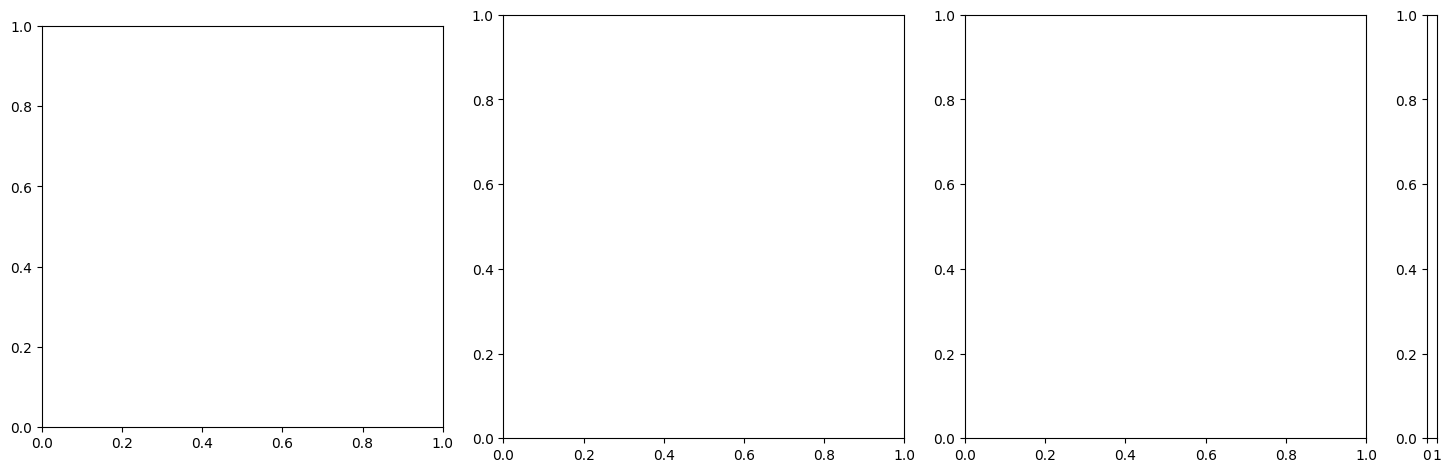

In [69]:
reg = 'SSp'
matrices =[main_dic[vis_epoch][(7777,7777,7777)] for vis_epoch in test_session.vis_epochs]
mat_new = []
for i in matrices:
    mat_new.append(subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, i, reg))
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(mat_new,layer_info,unique_layers,epochs,title = reg)

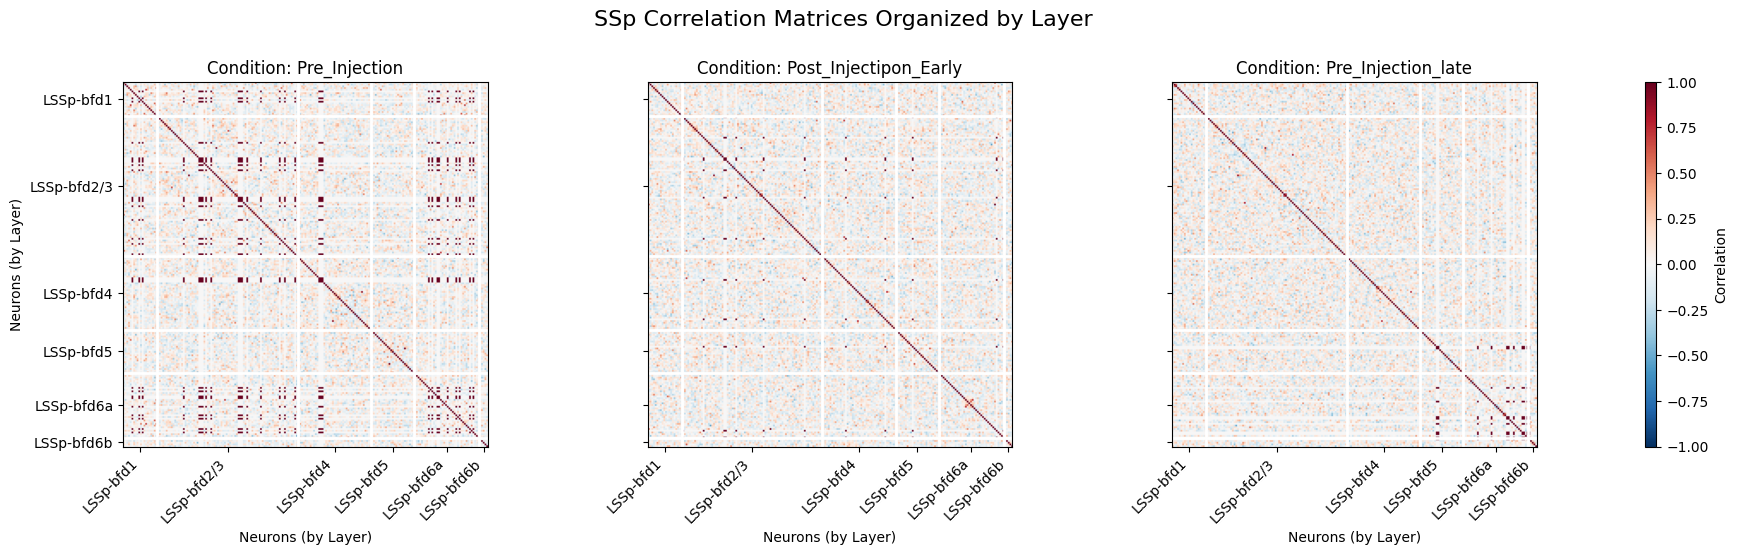

In [7]:
reg = "SSp"
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)
### cell type width 


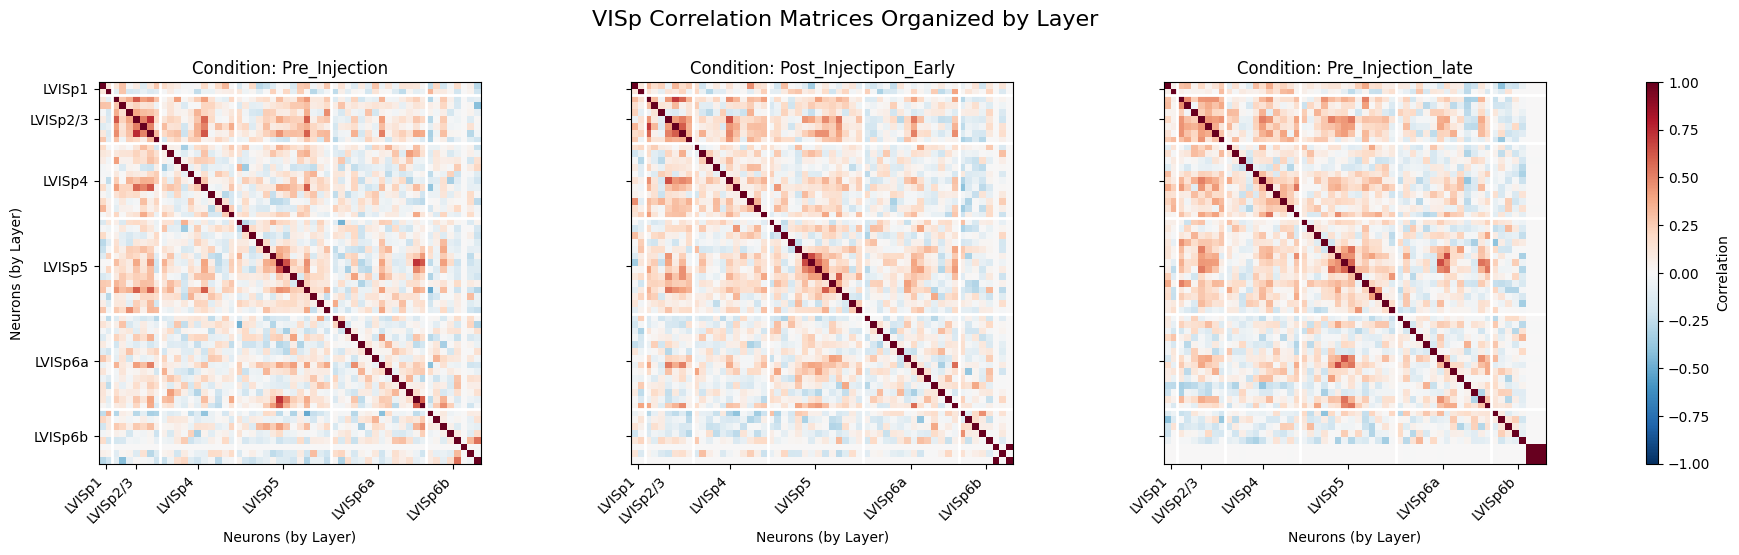

In [8]:
reg = "VISp"
matrices = []
for vis_epoch in  test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

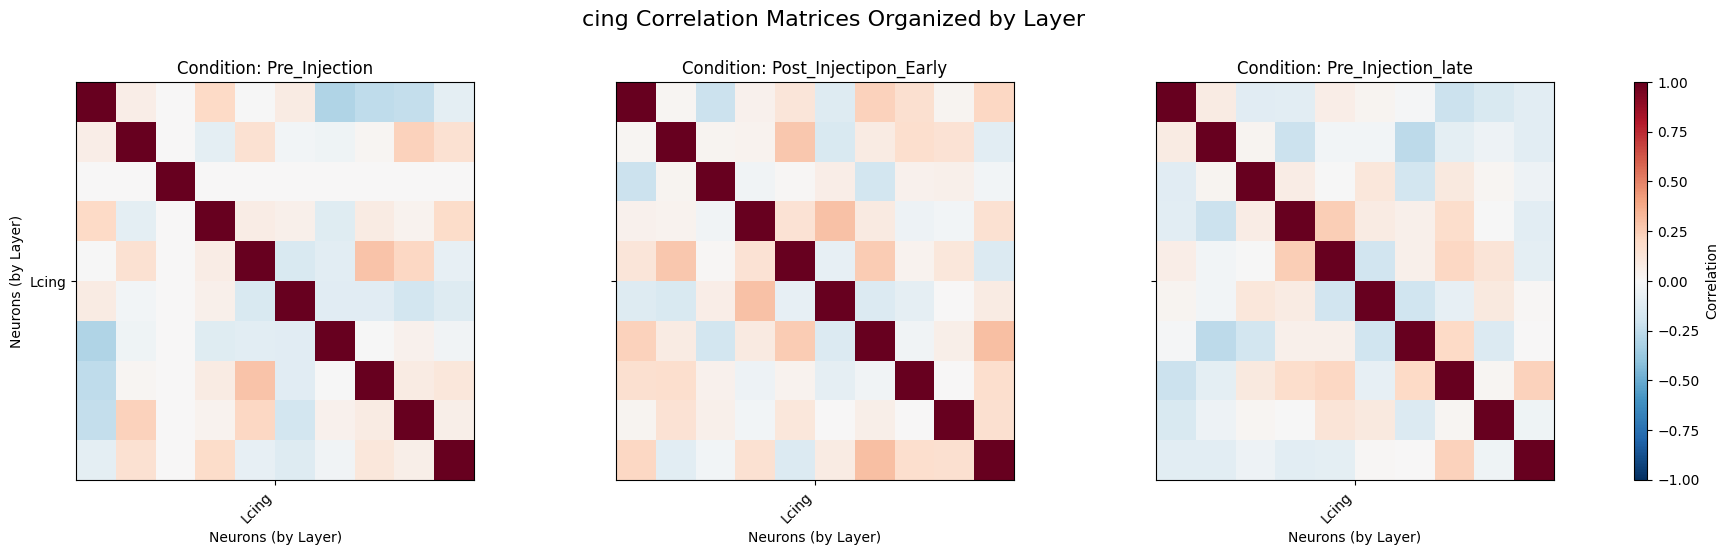

In [9]:
reg = "cing"
matrices = []
for vis_epoch in  test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

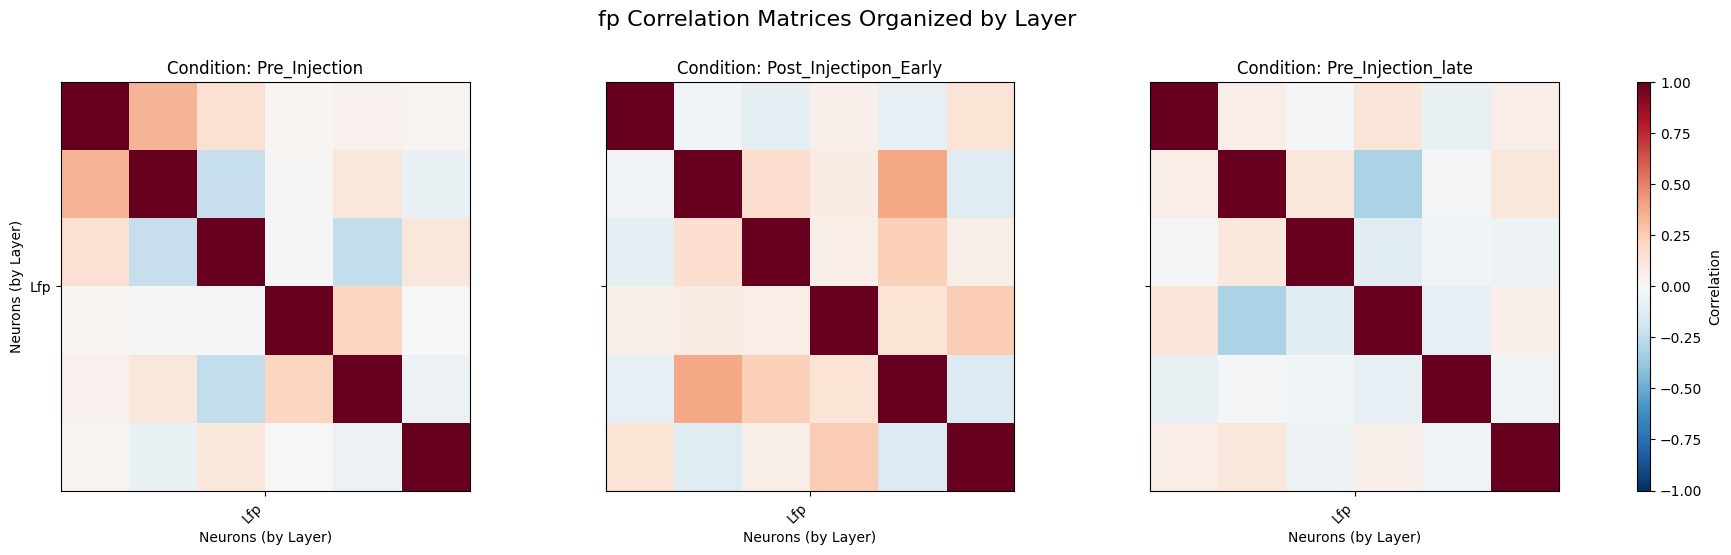

In [10]:
reg = "fp"
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

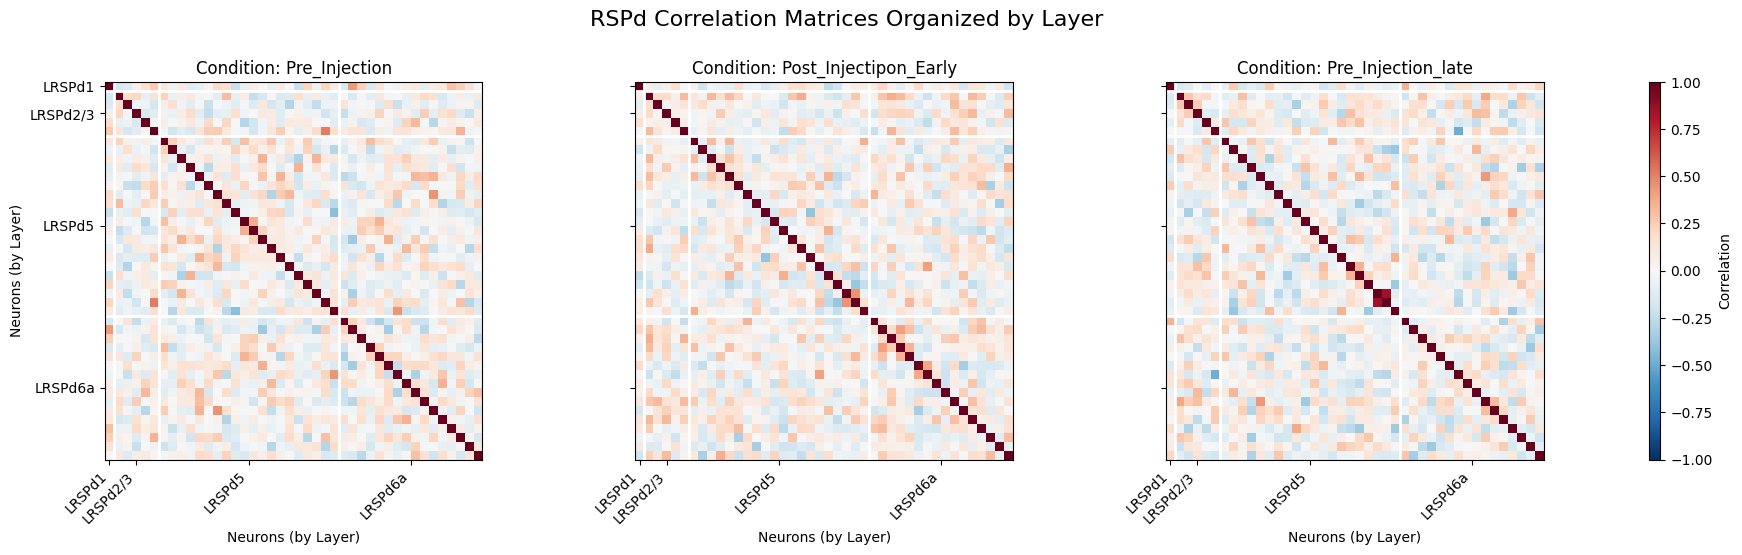

In [11]:
reg = 'RSPd'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

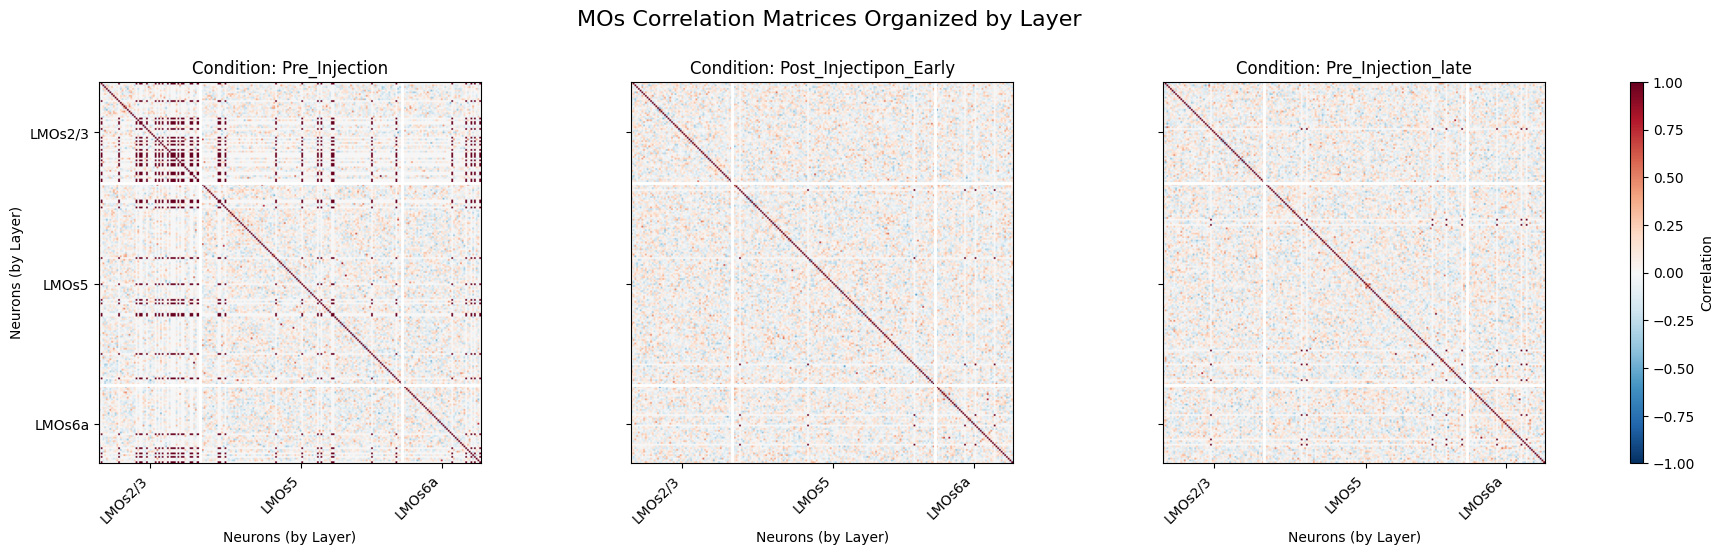

In [12]:
reg = 'MOs'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

In [17]:
epochs = ['Pre_Injection','Post_Injectipon_Early','Pre_Injection_late','Iso']

In [ ]:
session_path = '/home/tony/Halluci-Nations/scratch/ecephys_714527_2024-05-14_13-22-07_nwb_2025-08-03_21-11-22/'
test_session = hu_RFmapping_fr(session_path)
test_session.load_data()
test_session.get_vis_epochs_keys()

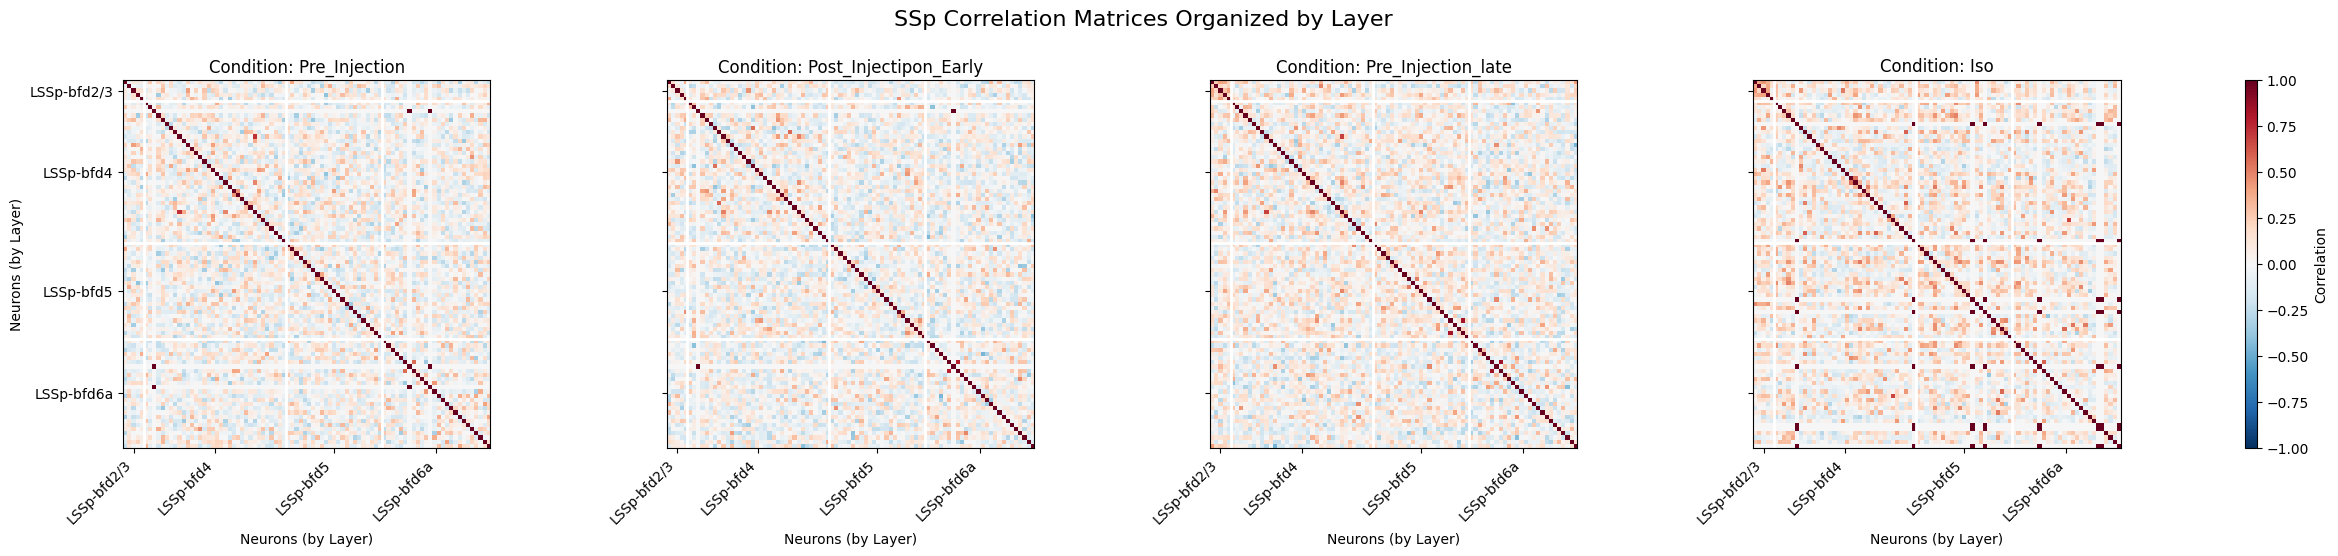

In [19]:
reg = 'SSp'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

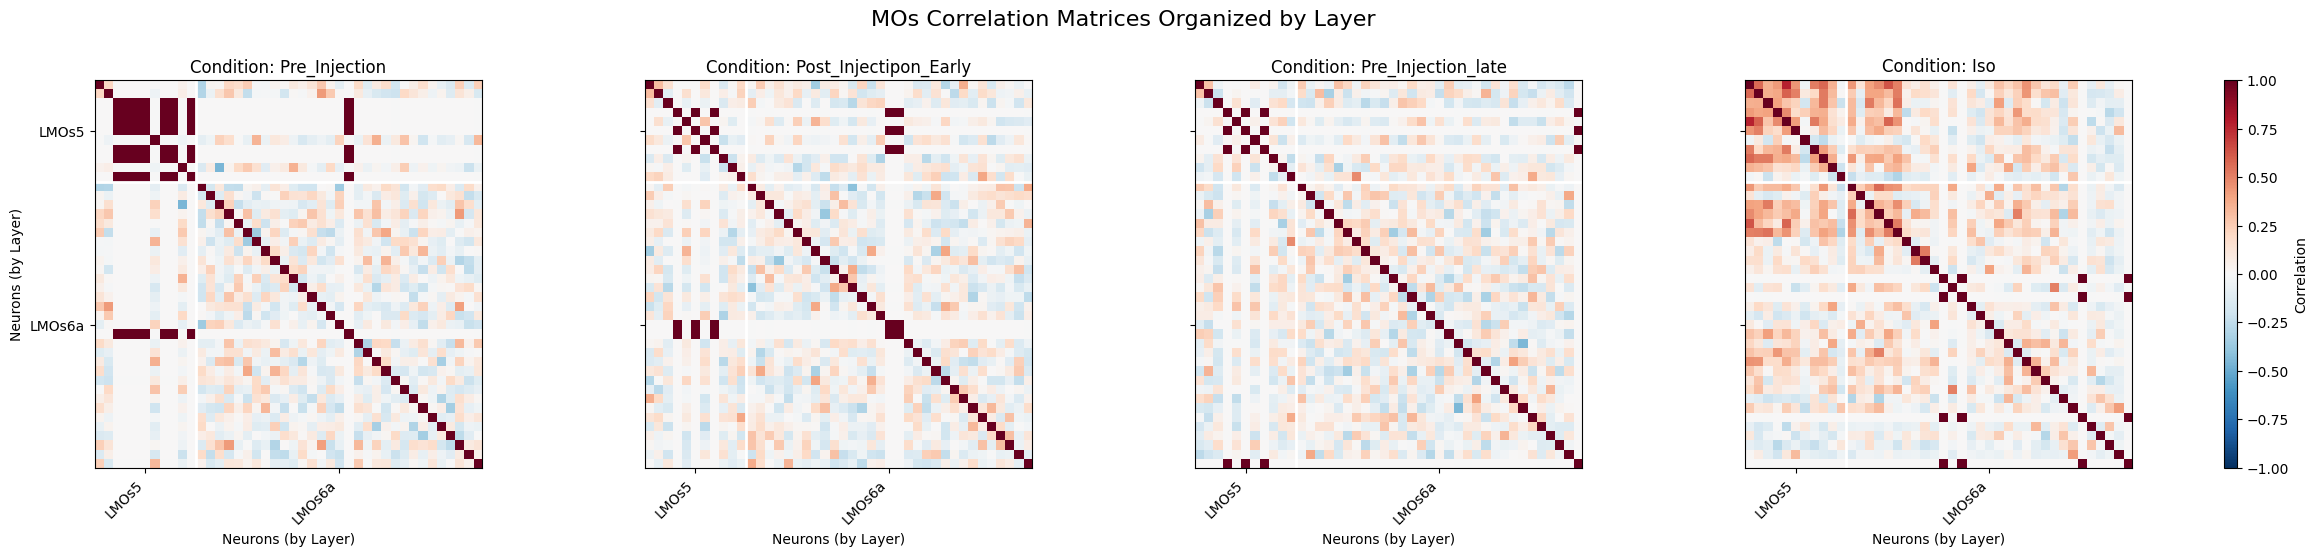

In [20]:
reg = 'MOs'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

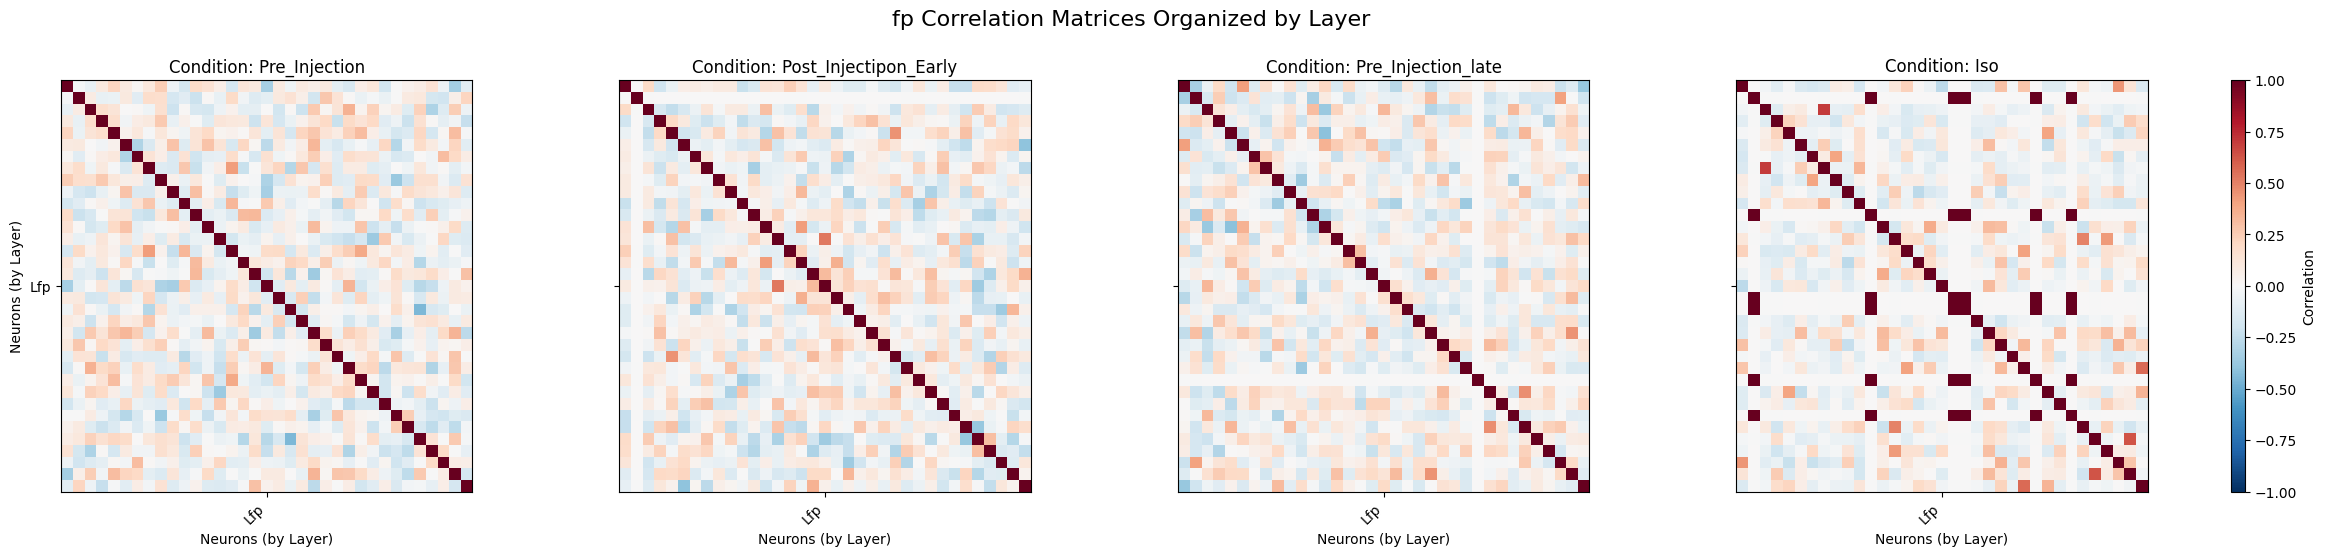

In [38]:
reg = 'fp'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

In [ ]:
reg = 'fp'
matrices = []
for vis_epoch in test_session.vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs,title = reg)

In [ ]:
layers = []
for unit_idx in range(len(analysis_table)):
    spike_times = analysis_table.iloc[unit_idx]['Spontaneous_0_spikes']
    if spike_times is None or len(spike_times) == 0:
        continue
    layers.append(analysis_table.iloc[unit_idx]['layer'])
layers = np.array(layers)
fr_matrix = firing_rate_matrix_spon0.copy()
# 2. Sort neurons by layer
sorted_indices = np.argsort(layers)
sorted_layers = layers[sorted_indices]
fr_matrix_sorted = fr_matrix[sorted_indices]
# 3. Compute correlation matrix
corr_matrix = np.corrcoef(fr_matrix_sorted)
# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='vlag', center=0, square=True, xticklabels=False, yticklabels=False)
plt.title("Neuron × Neuron Correlation (Grouped by Layer)", fontsize=14)
# 5. Optionally draw lines to show layer boundaries
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)
# Draw horizontal and vertical lines to separate layers
for boundary in layer_boundaries[:-1]:
    plt.axhline(boundary, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(boundary, color='gray', linestyle='--', linewidth=0.5)
# 6. Compute tick positions (center of each group)
tick_positions = layer_boundaries - counts // 2
# :white_check_mark: Fix: Make sure tick_positions and labels match in length
assert len(tick_positions) == len(unique_layers)
# Add layer labels
plt.yticks(tick_positions, unique_layers, fontsize=10)
plt.xticks(tick_positions, unique_layers, fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# get full correlation matrics do linear mixed modeling 
# filter connections for viewing #
# need to do some modeling 

In [ ]:
titles =  [i[0] for i in test[0]]
im2plot = [i[1] for i in test[0]]
reference_array = im2plot[0]  # The array to use for determining sort order

# Get the maximum value in each row
row_max_values = np.max(reference_array, axis=1)

# Get the indices that would sort by descending order (highest first)
sort_indices = np.argsort(row_max_values)[::-1]

# Apply this ordering to all arrays
sorted_array1 = im2plot[0][sort_indices]
sorted_array2 = im2plot[1][sort_indices]
sorted_array3 = im2plot[2][sort_indices]

In [ ]:
# Sort the arrays
reference_array = im2plot[0]
first_max_indices = np.argmax(reference_array, axis=1)
sort_indices = np.argsort(first_max_indices)

# Apply sorting to all arrays
sorted_im2plot = [arr[sort_indices] for arr in im2plot]

# Visualize before and after
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Original stacked image
original_stacked = np.hstack(im2plot)
im1 = ax1.imshow(original_stacked, aspect='auto', cmap='viridis')
ax1.set_title('Original Arrays')

# Sorted stacked image
sorted_stacked = np.hstack(sorted_im2plot)
im2 = ax2.imshow(sorted_stacked, aspect='auto', cmap='viridis')
ax2.set_title('Sorted by First Appearance of Maximum Value')

# Calculate tick positions based on actual array shapes
if 'titles' in locals():
    for ax in [ax1, ax2]:
        tick_positions = []
        array_widths = [arr.shape[1] for arr in im2plot]  # Get width of each array
        
        current_position = 0
        for width in array_widths:
            # Place tick at center of each array
            tick_positions.append(current_position + width/2 - 0.5)
            current_position += width
        
        tick_labels = [str(title) for title in titles]
        ax.set_xticks(tick_positions, tick_labels, rotation=45, ha='right')
        
        # Add separation lines based on actual widths
        current_position = 0
        for i, width in enumerate(array_widths[:-1]):  # Don't add line after last array
            current_position += width
            ax.axvline(x=current_position - 0.5, color='white', linestyle='-', linewidth=2, alpha=0.8)

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.tight_layout()
plt.show()

print(f"Rows are now ordered by column position of first max:")
print(f"Array shapes: {[arr.shape for arr in im2plot]}")
print(f"Array widths: {[arr.shape[1] for arr in im2plot]}")